# Observer

This Observer notebook monitors USB cameras for changes on the DMA playing field.

In [1]:
import asyncio, nest_asyncio
import json
import cv2
from collections import defaultdict
import threading
import numpy as np
import imutils
from matplotlib import pyplot as plt
from math import cos, acos, degrees, radians
from time import sleep, time
from datetime import datetime
import requests
import aiohttp
from dataclasses import dataclass
from traceback import format_exc
from uuid import uuid4
from typing import Optional

In [2]:
nest_asyncio.apply()

In [3]:
def distanceFormula(pt0, pt1):
    return sum([(pt1[i] - pt0[i])**2 for i in range(len(pt0))]) ** 0.5


def capture_camera(cam_num):
    try:
        cam = cv2.VideoCapture(cam_num)
        retval, image = cam.read()
    finally:
        cam.release()
    retval, buff = cv2.imencode('.jpg', image)
    return buff


MAX_CAM_ID = 10


def identify_usb_cameras(device_numbers=list(range(MAX_CAM_ID))):
    functional = []
    for dn in device_numbers:
        try:
            img = capture_camera(dn)
            functional.append(dn)
        except Exception as e:
            continue
    return functional


def hStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    images = [image if image is not None else np.zeros((10, 10, 3), np.uint8) for image in images]
    baseIm = None
    maxHeight = max([im.shape[0] for im in images])
    for im in images:    
        if im.shape[0] < maxHeight:
            addition = np.zeros((maxHeight - im.shape[0], im.shape[1], 3), np.uint8)
            im = np.vstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.hstack((
                baseIm,
                np.zeros((maxHeight, 10, 3), np.uint8),
                im))
    return baseIm


def vStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    images = [image if image is not None else np.zeros((10, 10, 3), np.uint8) for image in images]
    baseIm = None
    maxWidth = max([im.shape[1] for im in images])
    for im in images:    
        if im.shape[0] < maxWidth:
            addition = np.zeros((im.shape[0], maxWidth - im.shape[1], 3), np.uint8)
            im = np.hstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.vstack((
                baseIm,
                np.zeros((10, maxWidth, 3), np.uint8),
                im))
    return baseIm

def clipImage(image, clipBox):
    x, y, w, h = clipBox
    return image[int(y):int(y + h), int(x):int(x + w)]

In [4]:
@dataclass
class CameraChange:
    camName: str
    changeContours: list[np.array]
    before: np.array
    after: np.array
    changeType: str = "unclassified"
    lastChange: object = None

    ChangeTypes = ["add", "move", "delete", "unclassified"]

    def __post_init__(self):
        if self.changeContours is None:
            self.corner = None
            self.width = None
            self.height = None
            self.center = None
            self.before = None
            self.after = None
        else:
            self.area = max([cv2.contourArea(c) for c in self.changeContours])
            self.changePoints = [pt.tolist() for c in self.changeContours for d in c for pt in d]
            xS = [pt[0] for pt in self.changePoints]
            yS = [pt[1] for pt in self.changePoints]
            minX = max(min(xS) - 5, 0)
            minY = max(min(yS) - 5, 0)
            self.corner = [minX, minY]
            self.width = min(max(xS) - minX + 5, 1920)
            self.height = min(max(yS) - minY + 5, 1080)
            self.clipBox = [int(i) for i in (minX, minY, self.width, self.height)]
            self.center = [min(xS) + int(self.width / 2), min(yS) + int(self.height / 2)]
            
            beforeHeight, beforeWidth, *_ = self.before.shape
            if beforeHeight > self.height and beforeWidth > self.width:
                self.before = clipImage(self.before, self.clipBox)
                
            afterHeight, afterWidth, *_ = self.after.shape
            if afterHeight > self.height and afterWidth > self.width:
                self.after = clipImage(self.after, self.clipBox)

    def overrideChangeContours(self, newContours):
        self.changeContours = newContours
        self.area = max([cv2.contourArea(c) for c in self.changeContours])
        self.changePoints = [pt.tolist() for c in self.changeContours for d in c for pt in d]
        xS = [pt[0] for pt in self.changePoints]
        yS = [pt[1] for pt in self.changePoints]
        minX = max(min(xS) - 5, 0)
        minY = max(min(yS) - 5, 0)
        self.corner = [minX, minY]
        self.width = min(max(xS) - minX + 5, 1920)
        self.height = min(max(yS) - minY + 5, 1080)
        self.clipBox = [int(i) for i in (minX, minY, self.width, self.height)]
        self.center = [min(xS) + int(self.width / 2), min(yS) + int(self.height / 2)]

    def classify(self, changeType: str, lastChange: object=None):
        assert self.changeType is not None, "Unable to classify null ChangeType"
        assert changeType in self.ChangeTypes
        self.lastChange = lastChange
        self.changeType = changeType

    def changeOverlap(self, change):
        zeros = np.zeros(cameras[self.camName].mostRecentFrame.shape[:2], np.uint8)
        if self.changeType is None or change.changeType is None:
            return False
        changeIm = cv2.drawContours(zeros.copy(), self.changeContours, -1, 255, -1)
        otherIm = cv2.drawContours(zeros.copy(), change.changeContours, -1, 255, -1)
        overlap = cv2.bitwise_and(changeIm, otherIm)
        if overlap.any():
            contours = cv2.findContours(overlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
            largestArea = max([cv2.contourArea(c) for c in contours])
            overlapRatio = largestArea / self.area
            if 0.5 < overlapRatio < 2.0:
                return True
            else:
                print(f"Overlap ratio is too low: {overlapRatio}")
        return False

    def __eq__(self, other):
        if self.changeType in [None, 'delete']:
            return other is None or other.changeType in [None, 'delete']
        elif other is not None and other.changeType not in [None, 'delete']:
            return \
            (other.center[0] - 20 < self.center[0] < other.center[0] + 20) and \
            (other.center[1] - 20 < self.center[1] < other.center[1] + 20) and \
            (other.width - 20 < self.width < other.width + 20) and \
            (other.height - 20 < self.height < other.height + 20) and self.changeOverlap(other)
        else:
            return False
    
    def __repr__(self):
        return f"({self.changeType}) {self.center} by {self.width},{self.height}"
    
    def beforeAfter(self):
        return hStackImages([self.before, self.after])

In [5]:
@dataclass
class Camera:
    camName: str
    activeZone: list
    rotate: bool = False
    
    IMAGE_BUFFER_DEPTH = 7
    CAPTURE_FRAMES = 3
    CHANGE_THRESHOLD = 20
    MI = 2
    xmax = 2560
    ymax = 1920

    def __post_init__(self):
        self.imageBuffer = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.referenceFrame = None
        self.setActiveZone(self.activeZone)
        self.setReferenceFrame()
    
    @property
    def mostRecentFrame(self):
        return self.imageBuffer[0]
    
    def setReferenceFrame(self):
        self.referenceFrame = self.imageBuffer[1] if self.imageBuffer[1] is not None else self.imageBuffer[0]
    
    def getActiveZoneBoundingBox(self):
        if self.activeZone is None or len(self.activeZone) == 0:
            return 0, 0, 1920, 1080
        pts = np.int32(self.activeZone)
        return cv2.boundingRect(pts)
    
    @property
    def activeZoneBoundingBox(self):
        return self.getActiveZoneBoundingBox()
    
    def setActiveZone(self, newAZ):
        self.activeZone = np.float32(newAZ)
    
    def pointInActiveZone(self, p):
        return cv2.pointPolygonTest(self.activeZone, p, False) >= 0
    
    def collectImage(self) -> np.ndarray:
        cap = cv2.VideoCapture(self.camName)
        sleep(delay)
        image = None
        try:
            for frame in range(self.CAPTURE_FRAMES):
                ret, cv2_im = cap.read()
                sleep(delay)
            self.imageBuffer.insert(0, cv2_im)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        finally:
            cap.release()
        return image

    def contoursBetween(self, im0, im1):
        if im0 is None or im1 is None:
            return []
        img_height = im0.shape[0]
        diff = cv2.absdiff(cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))

        thresh = cv2.threshold(cv2.GaussianBlur(diff, (15, 25), 0), self.CHANGE_THRESHOLD, 255,cv2.THRESH_BINARY)[1]
        kernel = np.ones((3, 3), np.uint8) 
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        return cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    def changeBetween(self, changeFrame, referenceFrame):
        maskedRefFrame = self.maskFrameToActiveZone(referenceFrame)
        maskedChangeFrame = self.maskFrameToActiveZone(changeFrame)
        contours = self.contoursBetween(maskedRefFrame, maskedChangeFrame)
        
        newIm = changeFrame.copy()
        oldIm = referenceFrame.copy()
        boxes = []
        largeContours = []
        newClips = []
        oldClips = []
        
        filteredContours = []
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            x, y, w, h = bRect
            area = w * h
            if 1000 < area < 100000:
                filteredContours.append(contour)
        if len(filteredContours) > 0:
            # Create Before/After clips
            return CameraChange(self.camName, filteredContours, oldIm, newIm, changeType="unclassified")
        else:
            return CameraChange(self.camName, None, None, None, changeType=None)
    
    def referenceFrameDelta(self):
        return self.changeBetween(self.mostRecentFrame, self.referenceFrame)
    
    @staticmethod
    def swapBox(srcIm, dstIm, box):
        swapped = dstIm.copy()
        x, y, w, h = box
        swapped[y:y+h, x:x+w] = srcIm
        return swapped
    
    def changePatchDelta(self, change: CameraChange):
        patched = self.swapBox(change.before, self.referenceFrame, change.clipBox)
        return self.changeBetween(self.mostRecentFrame, patched)
    
    def capture(self):
        return self.collectImage()
    
    def cropToActiveZone(self, image):
        pts = np.int32(self.activeZone)
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        dst = cv2.bitwise_and(image, image, mask=mask)
        return dst
        
    def drawActiveZone(self, image):
        pts = np.int32(self.activeZone)
        azOverlaidImage = image.copy()
        return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(0,255,0), thickness=5)

    def maskFrameToActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        mask = np.zeros((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(mask, [np.array(self.activeZone, np.int32)], 255)
        return cv2.bitwise_and(frame, frame, mask=masked)
    
    def maskFrameToNonActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        zeroes = np.ones((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(zeroes, [np.array(self.activeZone, np.int32)], 0)
        return cv2.bitwise_and(frame, frame, mask=masked)

    @classmethod
    def drawBoxesOnImage(cls, image, boxes, color=(0,0,255)):
        imageWithBoxes = image.copy()
        for x, y, w, h in boxes:
            cv2.rectangle(imageWithBoxes, (x, y), (x+w, y+h), color, 2)
            presumedBasePoint = [x + int(w/2), y + int(h/2)]
            cv2.circle(imageWithBoxes, presumedBasePoint, radius=4, thickness=4, color=(0,255,255))
            cv2.putText(imageWithBoxes, f'{w*h}p-[{x}-{x+w}, {y}-{y+w}]', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
        return imageWithBoxes

In [6]:
@dataclass(kw_only=True)
class RemoteCamera(Camera):
    address: str
    auth: list[str] | None = None

    def collectImage(self, retries=5) -> np.ndarray:
        image = None
        try:
            for i in range(retries):
                resp_kwargs = {"url": self.address, "stream": True}
                if self.auth is not None:
                    resp_kwargs['auth'] = tuple(self.auth)
                resp = requests.get(**resp_kwargs).raw
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (1920, 1080))
                if self.rotate:
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                if image is not None:
                    break
            assert image is not None, f"Failed to collect image for Camera {self.camName} with {retries} attempts"
            
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        return image

    async def asyncCollectImage(self, retries: int = 5, timeout_s: float = 8.0,
                                session: aiohttp.ClientSession | None = None) -> np.ndarray | None:
        image = None
        owns_session = session is None
        auth_obj = aiohttp.BasicAuth(*self.auth) if getattr(self, "auth", None) else None
        timeout = aiohttp.ClientTimeout(total=timeout_s)

        try:
            if owns_session:
                session = aiohttp.ClientSession(timeout=timeout)

            for attempt in range(retries):
                try:
                    async with session.get(self.address, auth=auth_obj) as resp:
                        resp.raise_for_status()
                        data = await resp.read()

                    # Decode with OpenCV
                    arr = np.frombuffer(data, dtype=np.uint8)
                    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
                    if img is None:
                        raise ValueError("cv2.imdecode returned None")

                    img = cv2.resize(img, (1920, 1080))
                    if getattr(self, "rotate", False):
                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

                    image = img
                    break  # success

                except Exception as inner_exc:
                    print(f"[{self.camName}] attempt {attempt+1}/{retries} failed: {inner_exc}")
                    if attempt < retries - 1:
                        # exponential backoff: 0.2s, 0.4s, 0.8s, ...
                        await asyncio.sleep(0.2 * (2 ** attempt))
                        continue
                    raise Exception(f"Failed to collect image for Camera {self.camName} with {retries} attempts") from inner_exc # bubble up on final failure

            # Update buffer like original
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()

            return image

        except Exception as e:
            print(f"Failed to capture Camera {getattr(self, 'camName', '?')}: {e}")
            return None

        finally:
            if owns_session and session is not None:
                await session.close()

In [7]:
@dataclass(kw_only=True)
class RTSPCamera(RemoteCamera):
    """
    Continuous RTSP capture using a background thread.
    asyncCollectImage() becomes: wait for the next available frame (or latest).
    """

    # ---- RTSP URL ----
    @property
    def rtsp_url(self) -> str:
        # address should be like: "192.168.1.50:554/11" (SV3C)
        user, pw = self.auth
        return f"rtsp://{user}:{pw}@{self.address}"

    # ---- internal runtime state (not part of init) ----
    _cap_thread: threading.Thread = None
    _stop_evt: threading.Event = threading.Event()
    _lock: threading.Lock = threading.Lock()
    _latest_frame: np.ndarray = None
    _latest_seq: int = 0
    _latest_ts: float = 0.0

    _loop: asyncio.AbstractEventLoop = None
    _new_frame_evt: asyncio.Event = None

    def _ensure_asyncio_binding(self) -> None:
        """
        Ensure self._loop and self._new_frame_evt are bound to the *current* running loop.
        Safe to call from async context only.
        """
        loop = asyncio.get_running_loop()
        if self._loop is not loop or self._new_frame_evt is None:
            self._loop = loop
            self._new_frame_evt = asyncio.Event()
    
    # -------------------------
    # lifecycle
    # -------------------------
    def start_capture(self) -> None:
        """
        Start the background RTSP capture thread.
        Call this once from within an active asyncio event loop (before awaiting frames).
        """
        if self._cap_thread is not None and self._cap_thread.is_alive():
            return

        self._stop_evt = threading.Event()
        self._ensure_asyncio_binding()

        self._cap_thread = threading.Thread(target=self._capture_loop, daemon=True)
        self._cap_thread.start()

    def stop_capture(self) -> None:
        """
        Stop the background capture thread.
        """
        if self._cap_thread is None:
            return
        self._stop_evt.set()
        self._cap_thread.join(timeout=2.0)
        self._cap_thread = None

    # -------------------------
    # thread loop
    # -------------------------
    def _signal_frame(self) -> None:
        loop = self._loop
        evt = self._new_frame_evt
        if loop is not None and evt is not None:
            loop.call_soon_threadsafe(evt.set)

    def _open_cap(self) -> cv2.VideoCapture:
        cap = cv2.VideoCapture(self.rtsp_url, cv2.CAP_FFMPEG)
        try:
            cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        except Exception:
            pass
        return cap

    def _capture_loop(self) -> None:
        cap = self._open_cap()
        last_ok = time()

        try:
            while not self._stop_evt.is_set():
                if not cap.isOpened():
                    cap.release()
                    cap = self._open_cap()
                    continue

                ok, frame = cap.read()
                if not ok or frame is None or not frame.size:
                    # If we fail for a while, reopen the stream
                    if time() - last_ok > 2.0:
                        cap.release()
                        sleep(0.25)
                        cap = self._open_cap()
                        last_ok = time()
                    else:
                        sleep(0.01)
                    continue

                last_ok = time()

                with self._lock:
                    self._latest_frame = frame
                    self._latest_seq += 1
                    self._latest_ts = last_ok

                self._signal_frame()
        finally:
            cap.release()

    # -------------------------
    # frame access
    # -------------------------
    def collectImage(self, timeout_s: float = 5) -> np.ndarray:
        """
        Blocking API: waits until a *new* frame arrives (or returns latest if already available).
        Requires the capture thread to be started.
        """
        # If thread isn't running, fall back to old behavior (single-shot open/read/close)
        if self._cap_thread is None or not self._cap_thread.is_alive():
            return self._collectImage_oneshot(timeout_s=timeout_s)

        start = time()
        start_seq = self._latest_seq

        while time() - start < timeout_s:
            with self._lock:
                if self._latest_frame is not None and self._latest_seq > start_seq:
                    return self._latest_frame.copy()
            time.sleep(0.01)

        raise TimeoutError(f"Timed out waiting for RTSP frame after {timeout_s}s")

    def _collectImage_oneshot(self, timeout_s: float = 5) -> np.ndarray:
        """
        Your previous single-shot implementation retained as a fallback.
        """
        cap = cv2.VideoCapture(self.rtsp_url, cv2.CAP_FFMPEG)
        cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        try:
            start = time()
            if not cap.isOpened():
                raise RuntimeError("cv2.VideoCapture could not open RTSP stream")

            last_err = None
            while (time() - start) < timeout_s:
                ok, frame = cap.read()
                if ok and frame is not None and frame.size:
                    return frame
                last_err = "cap.read() returned no frame"
                time.sleep(0.03)
        finally:
            cap.release()

        raise TimeoutError(f"Timed out reading RTSP frame: {last_err}")

    async def asyncCollectImage(self, retries: int = 1, timeout_s: float = 5) -> np.ndarray | None:
        """
        Async API: waits for next frame from the background thread.
        Starts the capture thread on first use (must be called inside event loop).
        """
        self._ensure_asyncio_binding()
        
        if self._cap_thread is None or not self._cap_thread.is_alive():
            # start lazily the first time you await
            self.start_capture()

        image = None
        try:
            for attempt in range(retries):
                try:
                    pkt = await self._await_next_frame(timeout_s=timeout_s)
                    if pkt is None:
                        raise TimeoutError("Timed out waiting for RTSP frame")

                    img = pkt  # already a frame

                    # Normalize like your original code
                    img = cv2.resize(img, (1920, 1080))
                    if getattr(self, "rotate", False):
                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

                    image = img
                    break

                except Exception as inner_exc:
                    print(f"[{self.camName}] attempt {attempt+1}/{retries} failed: {inner_exc}")
                    if attempt < retries - 1:
                        await asyncio.sleep(0.2 * (2 ** attempt))
                        continue
                    raise Exception(
                        f"Failed to collect image for Camera {self.camName} with {retries} attempts"
                    ) from inner_exc

            # Update ring buffer
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()

            return image

        except Exception as e:
            print(f"Failed to capture Camera {getattr(self, 'camName', '?')}: {e}")
            return None

    async def _await_next_frame(self, timeout_s: float) -> Optional[np.ndarray]:
        self._ensure_asyncio_binding()
        evt = self._new_frame_evt
        assert evt is not None
    
        evt.clear()
        try:
            await asyncio.wait_for(evt.wait(), timeout=timeout_s)
        except asyncio.TimeoutError:
            return None
    
        with self._lock:
            if self._latest_frame is None:
                return None
            return self._latest_frame.copy()

In [8]:
@dataclass
class ChangeSet:
    changeSet: dict[str, CameraChange]
    
    @property
    def numCamerasChanged(self):
        return sum([change.changeType is not None for change in self.changeSet.values()])
    
    @property
    def empty(self):
        return sum([change.changeType is None for change in self.changeSet.values()]) == len(self.changeSet)

    @property
    def changeType(self):
        changeTypes = [change.changeType for change in self.changeSet.values() if change.changeType is not None]
        if sum([c == "delete" for c in changeTypes]) == len(changeTypes):
            return "delete"
        elif "move" in changeTypes or ("add" in changeTypes and "delete" in changeTypes):
            return "move"
        elif sum([c == "add" for c in changeTypes]) == len(changeTypes):
            return "add"
        else:
            raise Exception("Unrecognized changeType")
        
    def __eq__(self, other):
        if other is None:
            return False
        notNoneChanges = {camName: change for camName, change in self.changeSet.items() if change.changeType != None}
        if len(notNoneChanges) == 0:
            return False
        return \
            sum([notNoneChanges[camName] == other.changeSet[camName] for camName in notNoneChanges.keys()]) / len(notNoneChanges) >= 0.3
        
    def update(self, changeSet, overwrite=True):
        if overwrite:
            self.changeSet = changeSet.changeSet
        else:
            for camName, update in changeSet.changeSet.items():
                if update.changeType != None:
                    self.changeSet[camName] = update


@dataclass
class TrackedObject(ChangeSet):
    oid: str = None
    expectedChange: ChangeSet | None = None
    
    def __eq__(self, other):
        return super().__eq__(other)

    def __post_init__(self):
        if self.oid is None:
            self.oid = str(uuid4())

        try:
            self.icon = sorted([cs.after for cs in self.changeSet.values()
                                if cs is not None and cs.changeType != "delete"],
                               key=lambda x: x.size if x is not None else 0)[0]
        except:
            print("Failed to build TrackedObject icon")
            self.icon = np.zeros([100, 100], dtype="uint8")

    def __repr__(self):
        changeSet = {camName: cS for camName, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"TrackedObject({changeSet})"
    
    def previousVersion(self):
        return type(self)({camName: change.lastChange if change is not None else None for camName, change in self.changeSet.items()})
    
    @property
    def isNewObject(self):
        for camName, cS in self.changeSet.items():
            if cS is not None and cS.changeType not in ['add', None]:
                return False
        return True

    def update(self, changeSet, overwrite=True):
        super().update(changeSet, overwrite)
        self.icon = sorted([cs.after for cs in self.changeSet.values()
                            if cs is not None and cs.changeType != "delete"],
                           key=lambda x: x.size if x is not None else 0)[0]
        

In [9]:
cameras = {}

In [10]:
class CaptureConfiguration:
    def __init__(self, path="observerConfiguration.json"):
        self.loadConfiguration(path=path)

    def readConfigFile(self, path="observerConfiguration.json"):
        try:
            with open(path, "r") as f:
                config = json.loads(f.read())
        except:
            print("Failed to open Observer Configuration!")
            raise Exception("NoConfigurationFile")
        return config
    
    def loadConfiguration(self, path="observerConfiguration.json"):
        global cameras
        cameras = {}

        try:
            config = self.readConfigFile(path)
        except Exception as e:
            print(f"Unable to read configuration at {path}: {e}")
            config = {}

        for camName, camDef in config.items():
            if str(camName) == "pov":
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = RemoteCamera(address=addr, rotate=rot, activeZone=[], camName="pov")
            elif "RTSPCamera" in str(camName):
                name = camName.replace("RTSPCamera", "")
                addr = camDef['addr']
                rot = camDef['rot']
                auth = camDef.get("auth", None)
                az = np.float32(json.loads(camDef['az']))
                cameras[name] = RTSPCamera(address=addr, activeZone=az, camName=name, auth=auth)
            elif str(camName) not in ['rsc', 'calibrationPlan', 'hex']:
                addr = camDef['addr']
                rot = camDef['rot']
                auth = camDef.get("auth", None)
                az = np.float32(json.loads(camDef['az']))
                cameras[camName] = RemoteCamera(address=addr, activeZone=az, camName=camName, auth=auth)
        self.cameras = cameras
    
    def capture(self):
        return asyncio.run(self._capture_async())

    async def _capture_async(self):
        cams = [(cam.camName, cam) for cam in cameras.values() if cam is not None]
        results = await asyncio.gather(*(cam.asyncCollectImage() for _, cam in cams))
        self.lastCapture = {name: result for (name, _), result in zip(cams, results)}
        return self.lastCapture
    
    def setReference(self):
        for c in cameras.values():
            if c is not None:
                c.setReferenceFrame()
    
    def buildConfiguration(self):
        return {
            f"RTSPCamera{camName}" if isinstance(cam, RTSPCamera) else camName: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist()),
                "auth": cam.auth}
            for camName, cam in self.cameras.items()}

    def saveConfiguration(self, path="observerConfiguration.json"):
        with open(path, "w") as f:
            f.write(json.dumps(self.buildConfiguration(), indent=2))

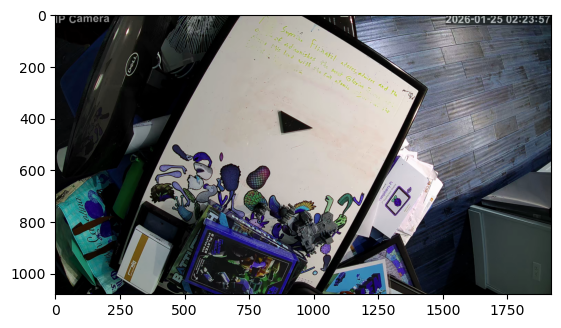

Duration: 2.9751408100128174


In [11]:
if __name__ == "__main__":
    cc = CaptureConfiguration(path="../observerConfiguration.json")
    start = time()
    for i in range(5):
        cc.capture()
    duration = time() - start
    for cam in cameras.values():
        plt.imshow(cam.mostRecentFrame)
        plt.show()
    print(f"Duration: {duration}")

In [12]:
@dataclass
class Transition:
    obj: TrackedObject
    cycle: int
    cameraChanges: dict[str, dict[str, np.array]]

In [13]:
class Observer:
    """ Object to observe the state of its cameras and record changes """
    states = ["idle", "unstable", "classify"]
    modes = ["passive", "track"]
    observationThreshold = 3

    def __init__(self, captureConfiguration: CaptureConfiguration):
        self.cc = captureConfiguration
        self.reset()
        self.minimumClassificationTime = 1

    def reset(self):
        self.cycleCounter = 0
        self.lastChanges = None
        self.lastClassification = None
        self.transitions = []
        self.memory = []
        self.lastMemory = None
        self.state = "idle"
        self.mode = "passive"
        self.cc.capture()
        self.cc.setReference()
    
    def interactionDetection(self):
        detections = {cam.camName: cam.interactionDetection(cam.mostRecentFrame) for cam in cameras.values()}
        return sum(detections.values()) > 0
    
    def updateReference(self):
        self.cc.setReference()
        
    def referenceFrameDeltas(self):
        return ChangeSet({
            camName: cam.referenceFrameDelta() 
                if self.mode != "passive" else
                CameraChange(camName, None, None, None, changeType=None)
            for camName, cam in cameras.items()})
    
    def memoriesInChangeOrder(self):
        changeOrderMemories = []
        if not self.transitions:
            return changeOrderMemories
        for transition in self.transitions[::-1]:
            if transition['obj'] not in changeOrderMemories:
                changeOrderMemories.append(transition['obj'])
                if len(changeOrderMemories) == len(self.memory):
                    return changeOrderMemories
        raise Exception("Failed to reconstruct memories in change order")
    
    def changeOverlaps(self, camera, change):
        changes = [m.changeSet[camera.camName] for m in self.memory]
        overlaps = []
        for eC in changes:
            if eC.changeType is not None and eC.changeOverlap(change) and eC not in overlaps:
                overlaps.append(eC)
        return overlaps

    def classifyCameraChange(self, camera, change: CameraChange):
        if change.changeType is None:
            return change

        overlaps = self.changeOverlaps(camera, change)
        if len(overlaps) == 0:  # Addition
            change.classify("add", CameraChange(None, None, None, None, None))
            return change
        elif len(overlaps) == 1:  # Move or Deletion
            cPD = camera.changePatchDelta(overlaps[0])
            if cPD.changeType is not None:  # Move
                patchedOverlaps = [o for o in self.changeOverlaps(camera, cPD) if o != overlaps[0]]
                if len(patchedOverlaps) != 0:
                    raise Exception(f"Unable to classify change: {change} interacting with {overlaps[0]} (patch has overlaps: {patchedOverlaps}")
                cPD.classify("move", overlaps[0])
                return cPD
            else:  # cPD == [], Deletion
                change.classify("delete", overlaps[0])
                return change
        else:
            raise Exception(f"Unable to classify change: {change}")

    def classifyChanges(self, changes):
        objDef = {}
        for camName, change in changes.changeSet.items():
            if change is not None:
                objDef[camName] = self.classifyCameraChange(cameras[camName], change)
            else:
                objDef[camName] = None
        return TrackedObject(changeSet=objDef)

    def camCommitChange(self, classifiedChange):
        overlaps = self.changeOverlaps(classifiedChange)
        assert classifiedChange.changeType != "unclassified", "Unable to commit unclassified changes"
        if classifiedChange.changeType == None:
            print(f"Cam {self.camName} - Nothing to commit")
        elif classifiedChange.changeType == "add":
            print(f"Cam {self.camName} - Adding {classifiedChange}")
            self.changes.insert(0, classifiedChange)
        elif classifiedChange.changeType == "move":
            print(f"Cam {self.camName} - Moving {classifiedChange.lastChange} to {classifiedChange}")
            self.changes.remove(classifiedChange.lastChange)
            self.changes.insert(0, classifiedChange)
        elif classifiedChange.changeType == "delete":
            print(f"Cam {self.camName} - Deleting {classifiedChange.lastChange} with {classifiedChange}")
            self.changes.remove(classifiedChange.lastChange)
        else:
            raise Exception(f"Cam {self.camName} - Unrecognzed changeType: {classifiedChange}")

    def commitChanges(self, objDef, overwrite=True):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            print(f"Updating Memory {existingIndex}")
            self.memory[existingIndex].update(objDef, overwrite=overwrite)
        except ValueError:
            print(f"New Memory")
            self.memory.append(objDef)
            existingIndex = len(self.memory) - 1
        self.lastMemory = objDef
        
        self.transitions.append(Transition(
            objDef,
            self.cycleCounter,
            {camName: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
             for camName, cam in cameras.items()}))
        return self.memory[existingIndex]

    def undoLastChange(self):
        if len(self.transitions) == 0:
            return

        lastChange = self.transitions[-1]
        changeObj = lastChange.obj
        if changeObj.isNewObject:
            self.deleteObject(changeObj.oid)
            self.transitions.pop()
        else:
            previousObj = changeObj.previousVersion()

            existingIndex = self.memory.index(changeObj)
            print(f"Updating Memory {existingIndex}-{changeObj.oid}")
            self.memory[existingIndex].update(previousObj)
            self.lastMemory = previousObj
        self.transitions.pop()
        self.passiveMode()

    def findObject(self, objectId):
        for capture in self.memory:
            if capture.oid == objectId:
                return capture
        raise Exception(f"Unable to find object: {objectId}")

    def deleteObject(self, oid):
        memCaps = {cap.oid: cap for cap in self.memory}
        if oid in memCaps:
            cap = memCaps[oid]
            self.memory.remove(cap)
        else:
            raise Exception(f"Unrecognized object: {oid}")

        self.transitions.append(Transition(
            cap,
            self.cycleCounter,
            {camName: CameraChange(None, None, None, "delete", cap.changeSet[camName])
             for camName, cam in cameras.items()}))

        self.lastMemory = {"deletedObject": oid}
        self.passiveMode()

    def cycleStatus(self):
        return f"{self.cycleCounter:5} -- {self}"
    
    def cycle(self):
        cycleStart = datetime.utcnow()
        try:
            print(self.cycleStatus())
            nextState = "idle"
            self.cc.capture()
            changes = self.referenceFrameDeltas()
            classification = None
            if self.mode == "passive" or changes.empty:
                self.cc.setReference()
            else:
                nextState = "unstable"
                if changes == self.lastChanges:  
                    nextState = "classify"
                    classification = self.classifyChanges(changes)
                    if self.state == "classify" and classification == self.lastClassification:
                        try:
                            nextState = "idle"
                            self.commitChanges(classification)
                            self.cc.setReference()
                        except AssertionError as ae:
                            print(f"Failed Classification: {ae}")
                            nextState = "unstable"
                            classification = None
                    else:
                        cycleEnd = datetime.utcnow()
                        if (cycleTime := (cycleEnd - cycleStart).total_seconds()) < self.minimumClassificationTime:
                            sleep(self.minimumClassificationTime - cycleTime)
                        
            self.state = nextState
            self.cycleCounter += 1
            self.lastChanges = changes
            self.lastClassification = classification
            return None
        except:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            self.passiveMode()
            self.lastChanges = None
            self.lastClassification = None
            return "Cycle Failure"
    
    def trackMode(self):
        self.mode = "track"
    
    def passiveMode(self):
        self.mode = "passive"
            
    def cycleForChange(self):
        self.mode = "track"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            try:
                self.cycle()
            except KeyboardInterrupt:
                break
        self.mode = "idle"
        return self.lastMemory
    
    def getCameraImagesWithChanges(self, cameraKeys=None):
        if cameraKeys is None:
            cameraKeys = self.cc.cameras.keys()

        images = {}
        for camName in cameraKeys:
            cam = self.cc.cameras[camName]
            camImage = cam.cropToActiveZone(cam.mostRecentFrame.copy())
            
            # Paint known objects blue
            for memObj in self.memory:
                if memObj.changeSet[camName].changeType not in ['delete', None]:
                    memContour = np.array([memObj.changeSet[camName].changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, memContour, -1, (255, 0, 0), -1)
            # Paint last changes red
            if self.lastChanges is not None and not self.lastChanges.empty:
                lastChange = self.lastChanges.changeSet[camName]
                if lastChange is not None and lastChange.changeType not in ['delete', None]:
                    lastChangeContour = np.array([lastChange.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastChangeContour, -1 , (0, 0, 255), -1)
            # Paint classification green
            if self.lastClassification is not None and not self.lastClassification.empty:
                lastClass = self.lastClassification.changeSet[camName]
                if lastClass is not None and lastClass.changeType not in ['delete', None]:
                    lastClassContour = np.array([lastClass.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastClassContour, -1 , (0, 255, 0), -1)
            camImage = cv2.resize(camImage, [480, 640], interpolation=cv2.INTER_AREA)
            images[camName] = camImage
        return images
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state}"

    def object_visual(self, changeSet: ChangeSet, color=(255, 0, 0), withContours=True, margin=0):
        cameras = self.cc.cameras
        images = [change.after for change in changeSet.changeSet.values() if change.changeType not in ["delete", None]]
        maxHeight =  max([im.shape[0] + margin * 2 for im in images])
        filler = np.zeros((maxHeight, 50, 3), np.uint8)
    
        margins = [-margin, -margin, margin * 2, margin * 2]
    
        if withContours:
            images = [clipImage(
                cv2.addWeighted(
                    cameras[camName].mostRecentFrame.copy(),
                    0.5,
                    cv2.drawContours(
                        cameras[camName].mostRecentFrame.copy(),
                        change.changeContours, 
                        -1,
                        color,
                        -1
                    ),
                    0.5,
                    0
                ),
                [dim + m for dim, m in zip(change.clipBox, margins)]
            ) if change.changeType != "delete" else filler for camName, change in changeSet.changeSet.items()]
        else:
            images = [clipImage(cameras[camName].mostRecentFrame.copy(), [dim + m for dim, m in zip(change.clipBox, margins)])
                      if change.changeType != "delete" else filler
                      for camName, change in changeSet.changeSet.items()]
            
        maxHeight =  max([im.shape[0] for im in images])
        filler = np.zeros((maxHeight, 50, 3), np.uint8)
        if not changeSet.empty:
            return hStackImages(images)
        else:
            return np.zeros([10, 10], dtype="float32")

    def expectObjectMovement(self, trackedObject: TrackedObject, expectedFinalLocation: tuple[int, int]):
        # Pass convert expectedFinalLocation to camera coords
        finalCamCoords = {cN: self.cc.rsc.realSpaceToCamCoord(expectedFinalLocation, cN) for cN in self.cc.cameras.keys()}
        # Determine the expected camera change
        trackedObject.expectedChange = ChangeSet(changeSet={cN: 
            CameraChange(
                camName=cN,
                changeContours=[self.circle_to_contour(finalCamCoords[cN], radius=10)],
                before=np.zeros([100, 100, 3], dtype="uint8"),
                after=np.zeros([100, 100, 3], dtype="uint8"),
                changeType="Add",
                lastChange=None
            ) for cN in self.cc.cameras.keys()})
        trackedObject.expectedChange.lastChange = trackedObject

    def clearExpectedMovement(self, trackedObject: TrackedObject):
        trackedObject.expectedChange = None

    def overlappingChangeSets(self, obj0: ChangeSet, obj1: ChangeSet):
        for camName, obj0_cameraChange in obj0.changeSet.items():
            obj1_cameraChange = obj1.changeSet[camName]
            if obj0_cameraChange.changeType in ["delete", None] or obj1_cameraChange.changeType in ["delete", None]:
                continue
            if not obj0_cameraChange.changeOverlap(obj1_cameraChange):
                return False

        return True

/tmp/ipykernel_590780/291220989.py:170: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  cycleStart = datetime.utcnow()


    0 -- CapMac -- passive idle


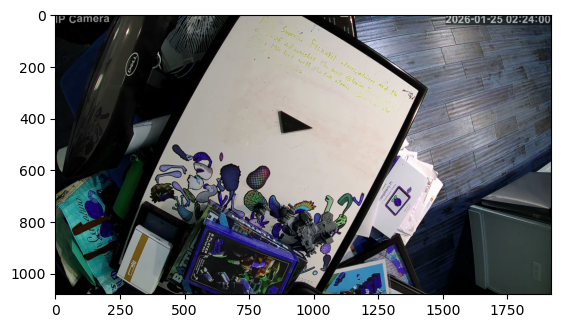

In [14]:
if __name__ == "__main__":
    o = Observer(cc)
    o.cycle()
    plt.imshow(cameras['0'].mostRecentFrame)

/tmp/ipykernel_130318/3693858513.py:170: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  cycleStart = datetime.utcnow()
/tmp/ipykernel_130318/3693858513.py:193: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  cycleEnd = datetime.utcnow()


New Memory
New Memory
New Memory


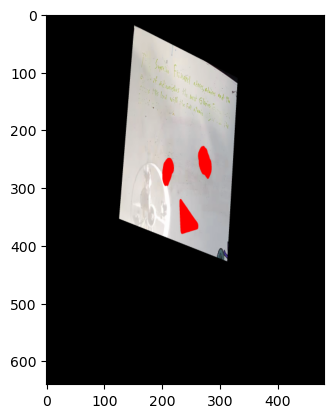

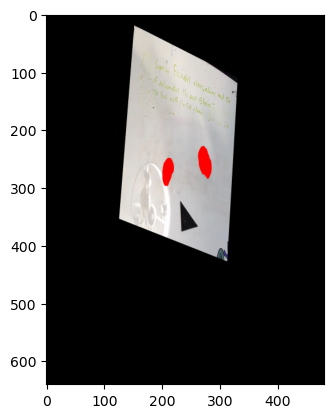

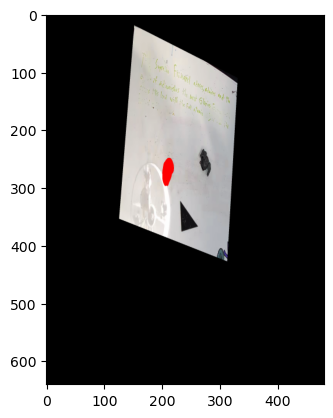

In [15]:
if __name__ == "__main__" and False:
    for i in range(3):
        o.cycleForChange()
    for i in range(3):
        o.cycle()
        
    plt.imshow(o.getCameraImagesWithChanges()['0'])
    plt.show()
    o.undoLastChange()
    plt.imshow(o.getCameraImagesWithChanges()['0'])
    plt.show()
    o.undoLastChange()
    plt.imshow(o.getCameraImagesWithChanges()['0'])